## Prophet

### Summary of Prophet

Like Scikit-Learn, we "create an instance of the Prophet class and then call its fit and predict methods.
The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast."


### Documentation
https://facebook.github.io/prophet/docs/quick_start.html


### Install
https://facebook.github.io/prophet/docs/installation.html#python

- conda install pystan
- conda install -c conda-forge fbprophet

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from acquire import get_store_data
from summarize import df_summary

df = get_store_data()

### Prepare the dataframe for modeling 

1. We are interested in forecasting total sales at store id 1. 
2. Prophet only takes data as a dataframe with a ds (datestamp) and y (value we want to forecast) column. So first, we convert the dataframe to the appropriate format.
    - Convert Date to a datetime format using the to_datetime() function.
    - Aggregate the y value, the measure as needed and and keep only that column and the datestamp.


In [35]:
ddf = df[df['store_id']==1]

In [36]:
ddf['y'] = ddf.sale_amount * ddf.item_price

In [37]:
ddf['ds'] = pd.to_datetime(ddf.sale_date)
ddf = ddf[['ds','y']]

In [38]:
ddf = ddf.groupby(['ds'])['y'].sum().reset_index()
ddf.head()

,ds,y
0,2013-01-01,7213.59
1,2013-01-02,6780.94
2,2013-01-03,7089.05
3,2013-01-04,7923.11
4,2013-01-05,8084.41


In [39]:
ddf.isnull().sum()

ds    0
y     0
dtype: int64

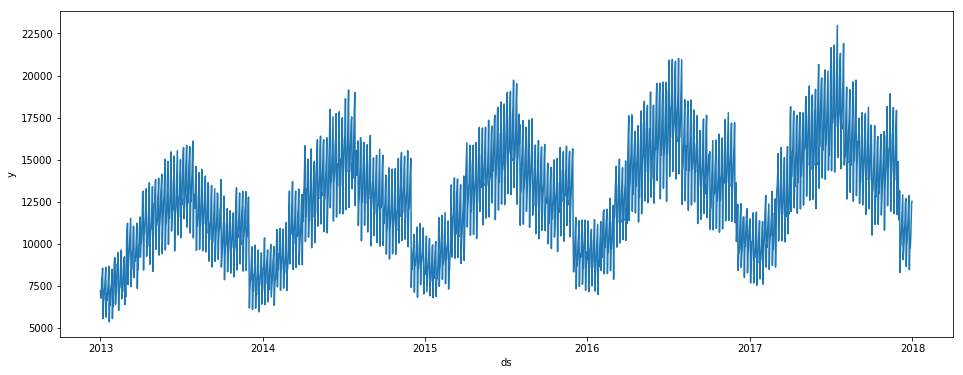

In [40]:
plt.figure(figsize=(16,6))
sns.lineplot(ddf.ds, ddf.y)

### Model

#### Create an instance of the Prophet class and then fit our dataframe to it

- Daily Seasonality
- Growth Max:  When forecasting growth, there is usually some maximum achievable point: total market size, total population size, etc. This is called the carrying capacity, and the forecast should saturate at this point.  Prophet allows you to make forecasts using a logistic growth trend model, with a specified carrying capacity.
- Saturating Min: The logistic growth model can also handle a saturating minimum, which is specified with a column floor in the same way as the cap column specifies the maximum

In [53]:
# ddf['cap'] = 600
# ddf['floor'] = 100

m = Prophet(daily_seasonality=True)
m.fit(ddf)

#### Create a "future" dataframe 

- Use make_future_dataframe() to create a dataframe with the dates for which we want a prediction
- Then specify the number of days to forecast using the periods parameter.

In [54]:
future = m.make_future_dataframe(periods=180)
# future['cap'] = 600
# future['floor'] = 100

future.head()
future.tail()

print(future.ds.min())
print(future.ds.max())
print(ddf.ds.min())
print(ddf.ds.max())

2013-01-01 00:00:00
2018-06-29 00:00:00
2013-01-01 00:00:00
2017-12-31 00:00:00


#### Predict

Call predict to make a prediction and store it in the forecast dataframe. In that df you will see the the predictions as well as the lower and upper boundaries of the uncertainty interval.

In [55]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# forecast.tail()

,ds,yhat,yhat_lower,yhat_upper
2001,2018-06-25,15332.330722,14500.877872,16182.699960
2002,2018-06-26,17029.204027,16139.692868,17904.447070
2003,2018-06-27,17141.551319,16269.723216,17995.888850
2004,2018-06-28,17982.900660,17047.648430,18860.793972
2005,2018-06-29,18859.184043,17986.069028,19724.117707


### Plot

Next, plot the forecast by calling plot and passing in the forecast dataframe. The black dots represent outliers and the light-blue shaded regions, the uncertainty intervals.

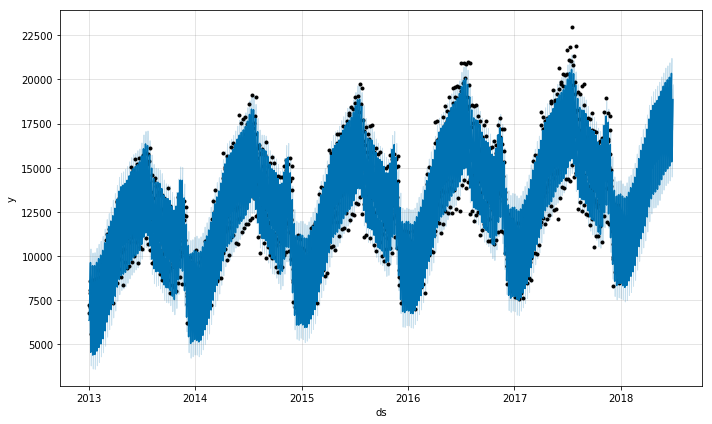

In [56]:
fig1 = m.plot(forecast)

We can break this down a bit further by calling the plot_components() method to inspect the forecast components.

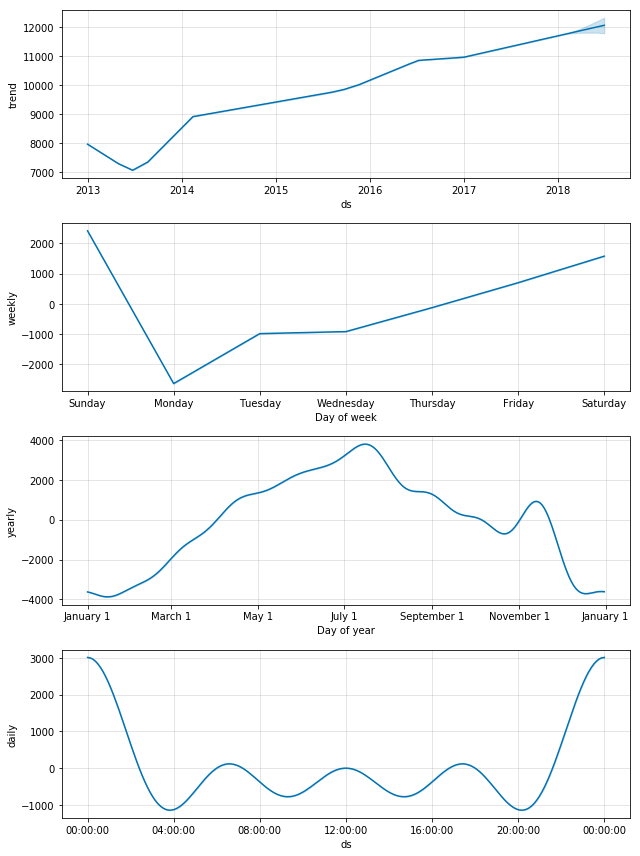

In [57]:
fig2 = m.plot_components(forecast)

### Evaluate

Evaluate the forecast using Prophet’s cross validation procedure.

Use the cross_validation() function on the model and specify the forecast horizon with the horizon parameter.
Next, call performance_metrics() to get a table with various prediction performance metrics.

In [59]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='90 days')

INFO:fbprophet:Making 33 forecasts with cutoffs between 2013-10-23 00:00:00 and 2017-10-02 00:00:00


In [60]:
df_p = performance_metrics(df_cv)

In [61]:
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
278,9 days,984926.528984,992.434647,697.190299,0.060360,0.626263
1899,10 days,989850.647723,994.912382,700.644200,0.060516,0.622896
369,10 days,991443.577336,995.712598,701.636948,0.060577,0.619529
639,10 days,990465.317753,995.221241,699.844016,0.060394,0.619529
729,10 days,990458.069531,995.217599,699.721292,0.060387,0.619529
